<a href="https://colab.research.google.com/github/erika0915/artificial-intelligence/blob/main/mlp/06_lr_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Learning Rate 변화 실험
- 모델 구조 : 512 유닛 MLP
- 옵티마이저 : Adam
- 학습률 비교 : 1.0/0.1/0.01

100%|██████████| 9.91M/9.91M [00:00<00:00, 42.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.20MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.9MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.49MB/s]



 Learning Rate: 1.0
[1/10] Loss: 24.0879
[2/10] Loss: 16.0864
[3/10] Loss: 15.5225
[4/10] Loss: 15.3098
[5/10] Loss: 17.0174
[6/10] Loss: 17.2818
[7/10] Loss: 14.5320
[8/10] Loss: 15.0242
[9/10] Loss: 16.1100
[10/10] Loss: 17.1776
 총 학습 시간: 269.76초
Test Loss: 23.7875 | Accuracy: 51.04%

 Learning Rate: 0.1
[1/10] Loss: 1.6157
[2/10] Loss: 1.3182
[3/10] Loss: 1.2117
[4/10] Loss: 1.1734
[5/10] Loss: 1.2021
[6/10] Loss: 1.1372
[7/10] Loss: 1.1973
[8/10] Loss: 1.2947
[9/10] Loss: 1.3474
[10/10] Loss: 1.2833
 총 학습 시간: 252.31초
Test Loss: 1.1503 | Accuracy: 78.62%

 Learning Rate: 0.01
[1/10] Loss: 0.2584
[2/10] Loss: 0.1957
[3/10] Loss: 0.1873
[4/10] Loss: 0.1771
[5/10] Loss: 0.1806
[6/10] Loss: 0.1693
[7/10] Loss: 0.1684
[8/10] Loss: 0.1617
[9/10] Loss: 0.1577
[10/10] Loss: 0.1547
 총 학습 시간: 329.15초
Test Loss: 0.1650 | Accuracy: 95.40%


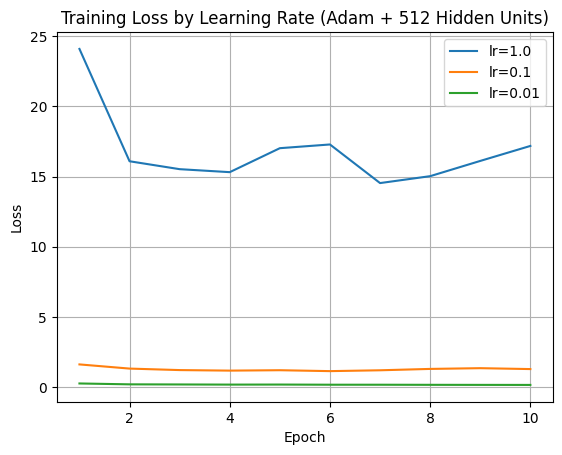

In [1]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# 1. 데이터 전처리 및 로딩
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False)

# 2. 512-unit MLP 모델
class WideMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 512)
        self.act = nn.Sigmoid()
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.act(self.fc1(x))
        x = self.fc2(x)
        return x

# 3. 학습 및 평가 함수
def train_with_lr(learning_rate):
    print(f'\n Learning Rate: {learning_rate}')
    model = WideMLP().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    loss_history = []
    start_time = time.time()
    for epoch in range(10):
        model.train()
        running_loss = 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        epoch_loss = running_loss / len(trainloader.dataset)
        loss_history.append(epoch_loss)
        print(f"[{epoch+1}/10] Loss: {epoch_loss:.4f}")
    total_time = time.time() - start_time
    print(f" 총 학습 시간: {total_time:.2f}초")

    # 테스트 정확도
    model.eval()
    correct, test_loss = 0, 0.0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            test_loss += criterion(outputs, labels).item() * images.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
    test_loss /= len(testloader.dataset)
    accuracy = correct / len(testloader.dataset) * 100
    print(f"Test Loss: {test_loss:.4f} | Accuracy: {accuracy:.2f}%")
    return loss_history, accuracy

# 4. 실험 실행
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_lr1, acc_lr1 = train_with_lr(1.0)
loss_lr01, acc_lr01 = train_with_lr(0.1)
loss_lr001, acc_lr001 = train_with_lr(0.01)

# 5. 시각화
plt.figure()
plt.plot(range(1, 11), loss_lr1, label='lr=1.0')
plt.plot(range(1, 11), loss_lr01, label='lr=0.1')
plt.plot(range(1, 11), loss_lr001, label='lr=0.01')
plt.title('Training Loss by Learning Rate (Adam + 512 Hidden Units)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
